In [319]:
import cooler
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import cooltools.lib.plotting
import pyBigWig
import matplotlib.pyplot as plt
import numpy as np
from typing import Self
import glob

from matplotlib.patches import Rectangle

# Core functions

In [320]:
import matplotlib
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)

In [336]:
class stripeSet:
    bp_formatter = EngFormatter('b')
    def __init__(self, cool, norm, stripes, name, bed_path = None, bg_paths_list = []):
        self.Lib = cooler.Cooler(cool)
        PossibleNorm = self.Lib.bins().columns
        self.name = name
        if norm == 'None':
            self.norm = False
        elif norm == 'weight':
            self.norm = True
        elif norm not in PossibleNorm:
            print('Possible normalization methods are:')
            print('None')
            for n in range(3,len(PossibleNorm)):
                print(PossibleNorm[n])
            print("Invalid normalization method. Normalization method is forced to None")
            self.norm = False

        self.stripes = pd.read_table(stripes)
        self.unbalLib = self.Lib.matrix(balance=self.norm)
        self.bws_list = [pd.read_table(p,header=None,names=["chr","start","end","value"]) for p in bg_paths_list]
        if bed_path is not None:
            self.priors = pd.read_table(bed_path, header=None)
            print(self.priors.head())
            self.priors.iloc[:,1] = self.priors.iloc[:,1].astype(int)
            self.priors.iloc[:,2] = self.priors.iloc[:,2].astype(int)
        else:
            self.priors = None
    
    @classmethod
    def from_results_folder(cls, results_base_path, name) -> Self:
        stripes_path = results_base_path + "/result_unfiltered_removeredundant.tsv"
        logfile = glob.glob(results_base_path + "/*.log")[0]
        with open (logfile, "r") as log:
            log = log.readlines()
            print(''.join(log))
            for line in log:
                if "cool:" in line:
                    cool_path = line.split()[1]
                if "bed:" in line:
                    bed_path = line.split()[1]

        return stripeSet(cool_path, 'None', stripes_path, name=name, bed_path=bed_path)

    def _format_ticks(self, ax, x=True, y=True, rotate=True):
        if y:
            ax.yaxis.set_major_formatter(self.bp_formatter)
        if x:
            ax.xaxis.set_major_formatter(self.bp_formatter)
            ax.xaxis.tick_bottom()
        if rotate:
            ax.tick_params(axis='x',rotation=45)
    
    def plot_stripe(self, ax, pos1, pos2, pos3, pos4, length, width):
        #print(pos2-pos1)
        #print(pos4-pos3)
        ax.add_patch(
            Rectangle(xy=(pos1, pos3), height=length,
                    width=width, facecolor='none', edgecolor='green', lw=1.5)
        )

    
    def visualize_rectangular_region_contact_map_and_stripes (self, ax, chrom, start_x, end_x, start_y, end_y, window_size_bp_x =0, window_size_bp_y=0,**kwargs):
        expansion_x = max(int((window_size_bp_x - (end_x - start_x))/2),0)
        expansion_y = max(int((window_size_bp_y - (end_y - start_y))/2),0)

        plot_region_start_x = int(max(start_x-expansion_x,0))
        plot_region_end_x = int(min(end_x+expansion_x, self.Lib.chromsizes[chrom]))

        plot_region_start_y = int(max(start_y-expansion_y,0))
        plot_region_end_y = int(min(end_y+expansion_y, self.Lib.chromsizes[chrom]))

        region_x=str(chrom)+':'+str(plot_region_start_x)+'-'+str(plot_region_end_x)
        region_y=str(chrom)+':'+str(plot_region_start_y)+'-'+str(plot_region_end_y)
        print("region x:",region_x)
        print("region y:",region_y)
        section = self.unbalLib.fetch(region_y, region_x)

        stripes_in_region = self.stripes[(self.stripes['chr'] == chrom)&((self.stripes['pos1'] > plot_region_start_x) & (self.stripes['pos1'] < plot_region_end_x)|((self.stripes['pos2'] > plot_region_start_x) & (self.stripes['pos2'] < plot_region_end_x)))]

        im = ax.matshow(section,cmap="fall",extent=(plot_region_start_x, plot_region_end_x, plot_region_end_y, plot_region_start_y),**kwargs);
        print("stripes")
        print(stripes_in_region)
        for idx in stripes_in_region.index:
            self.plot_stripe(ax, *stripes_in_region.loc[idx, ['pos1', 'pos2', 'pos3', 'pos4','length','width']])
        
        if self.priors is not None:
            priors_in_region = self.priors[(self.priors.iloc[:,0] == chrom)&((self.priors.iloc[:,1] > plot_region_start_x) & (self.priors.iloc[:,2] < plot_region_end_x))].reset_index(drop=True)
            print("priors")
            print(priors_in_region)
            for idx in priors_in_region.index:
                #mp = (priors_in_region.iloc[idx, 1] + priors_in_region.iloc[idx, 2])//2
                #ax.vlines(priors_in_region.iloc[idx, 1], plot_region_start_y, plot_region_end_y, color='blue', lw=0.5)
                #ax.hlines(priors_in_region.iloc[idx, 1], plot_region_start_x, plot_region_end_x, color='blue', lw=0.5)
                ax.plot(priors_in_region.iloc[idx, 1],priors_in_region.iloc[idx, 1], 'bo', markeredgecolor="white", markersize=10)
            
        plt.colorbar(im, ax=ax ,fraction=0.046, pad=0.04, label='raw counts');


In [337]:
lococo_200 = stripeSet.from_results_folder("50_200bp/2024-12-18_11-41-01_stripesearch_resol_200_chr_19_canny_2.0_minL_5_maxW_8_maxpixel_0.95_numcores_4_pvalue_0.1_slow_True_bfilter_1_seed_123456789_windowSize_100_expansionLength_5_method_lococo_", "lococo_200bp")

cool: /Users/amulyagarimella/Desktop/Xia_Lab/J/data/hct_wt_merge_all_1.48B_UU_dedup.pairs_50bp.mcool::resolutions/500
bed: /Users/amulyagarimella/Desktop/Xia_Lab/J/outputs/2024-12-18_03-57-30_stripe_prior_results_resolution_500bp_windowsize_20Mb_stepsize_20Mb_sumwindowsize_1000kb_peakwindowsize_1000kb_threshold_0.5_lambdawindowsizesbp_10000_100000_1000000_chromosomes_19/prior_peaks_all_chromosomes_peak_calling_threshold_0.5_resolution_500bp_windowsize_20Mb_stepsize_20Mb_sumwindowsize_1000kb_peakwindowsize_1000kb_threshold_0.5_lambdawindowsizesbp_10000_100000_1000000_chromosomes_19_p_5e-08_random0.5.bed
signal: /Users/amulyagarimella/Desktop/Xia_Lab/J/outputs/2024-12-18_03-57-30_stripe_prior_results_resolution_500bp_windowsize_20Mb_stepsize_20Mb_sumwindowsize_1000kb_peakwindowsize_1000kb_threshold_0.5_lambdawindowsizesbp_10000_100000_1000000_chromosomes_19/allpeaks_chr19.bed
region: 
out: /Users/amulyagarimella/Desktop/Xia_Lab/J/outputs/2024-12-18_11-32-03_stripesearch_resol_500_chr_19_

In [347]:
example_stripe = lococo_200.stripes.loc[3]

region x: chr19:512500-587500
region y: chr19:512501-587501
stripes
     chr      pos1      pos2   chr2      pos3      pos4   length   width  \
3  chr19  549500.0  550500.0  chr19  528501.0  571501.0  43000.0  1000.0   
4  chr19  555500.0  556500.0  chr19  534501.0  571501.0  37000.0  1000.0   

    total       Mean  ...    x    y     h    w  medpixel  region_idx  \
3  1614.0   9.383721  ...  4.0  6.0  86.0  2.0       3.0           3   
4  1884.0  12.729730  ...  4.0  6.0  74.0  2.0       3.0           4   

   region_start  region_end        pvalue  Stripiness  
3        547500      553000  3.004770e-10    0.707435  
4        553500      559000  1.118954e-05    0.743195  

[2 rows x 24 columns]
priors
       0       1       2  3    4    5           6           7         8  \
0  chr19  550000  550500  -  332  610  328.865672  396.014925  0.417139   
1  chr19  556000  556500  -  370  726  338.626866  430.952381  0.043188   

              9  
0  9.020827e-24  
1  1.058238e-38  


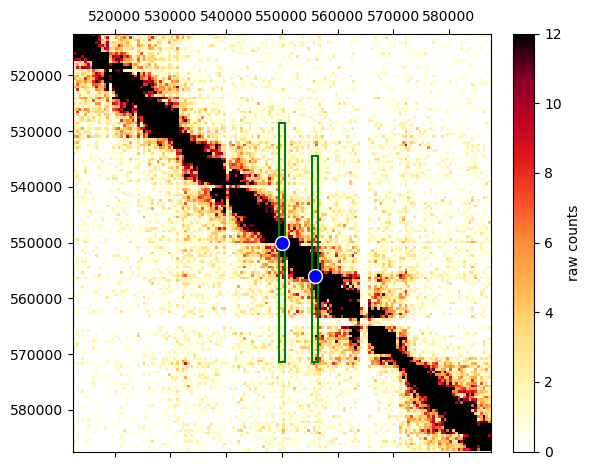

In [348]:
ax = plt.gca()
lococo_200.visualize_rectangular_region_contact_map_and_stripes(chrom='chr19', start_x=example_stripe['pos1'], end_x=example_stripe['pos2'], start_y=example_stripe['pos3'], end_y=example_stripe['pos4'], vmax=12, window_size_bp_x=75000, window_size_bp_y=75000, ax = ax,)
plt.tight_layout()
plt.savefig("lococo_200_example.svg")